In [1]:
%load_ext autoreload
%autoreload 2

In [63]:
import os, sys
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
sys.path.append('../../reproducible_figures/scripts/')
import rep_fig_vis as rfv
sys.path.append('../scripts/')
from loadpaths_glc import loadpaths
import data_loading_utils as dlu
import glc_prediction_utils as gpu
path_dict = loadpaths()
import h3pandas

In [60]:
dict_dfs, dict_dfs_species, _ = dlu.load_metadata(drop_duplicates=False)

Columns dropped: ['taxonRank', 'geoUncertaintyInM', 'date', 'areaInM2', 'publisher', 'month', 'day', 'region', 'dayOfYear', 'country']



----
df_train_pa: 88987 samples
Index(['lng', 'lat', 'year', 'surveyId'], dtype='object')
Unique surveys: 88987
Unique species: 5016

----
df_train_po: 3845533 samples
Index(['lng', 'lat', 'year', 'surveyId'], dtype='object')
Unique surveys: 3845533
Unique species: 9709

----
df_test_pa: 4716 samples
Index(['lng', 'lat', 'year', 'surveyId'], dtype='object')
Unique surveys: 4716
Unique species: NA


/Users/t.vanderplas/anaconda3/envs/geoclef/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/t.vanderplas/anaconda3/envs/geoclef/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/t.vanderplas/anaconda3/envs/geoclef/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/t.vanderplas/anaconda3/envs/geoclef/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

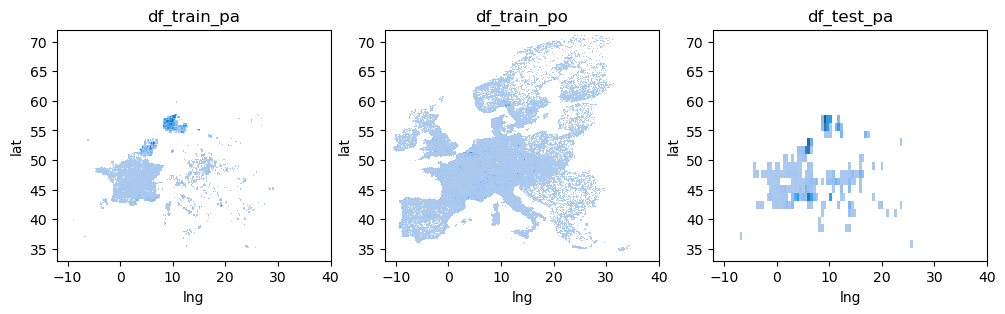

In [73]:
for key, df in dict_dfs.items():
    print('\n----')
    print(f'{key}: {df.shape[0]} samples')
    print(df.columns)
    n_unique_samples = df['surveyId'].nunique()
    if 'test' not in key:
        n_unique_species = dict_dfs_species[key + '_species']['speciesId'].nunique()
    else:
        n_unique_species = 'NA'
    print(f'Unique surveys: {n_unique_samples}')
    print(f'Unique species: {n_unique_species}')

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
# ax = ax.flatten()
for i, key in enumerate(dict_dfs.keys()):
    df = dict_dfs[key]
    sns.histplot(data=df, x='lng', y='lat', ax=ax[i])
    ax[i].set_title(key)
    ax[i].set_xlim([-12, 40])
    ax[i].set_ylim([33, 72])

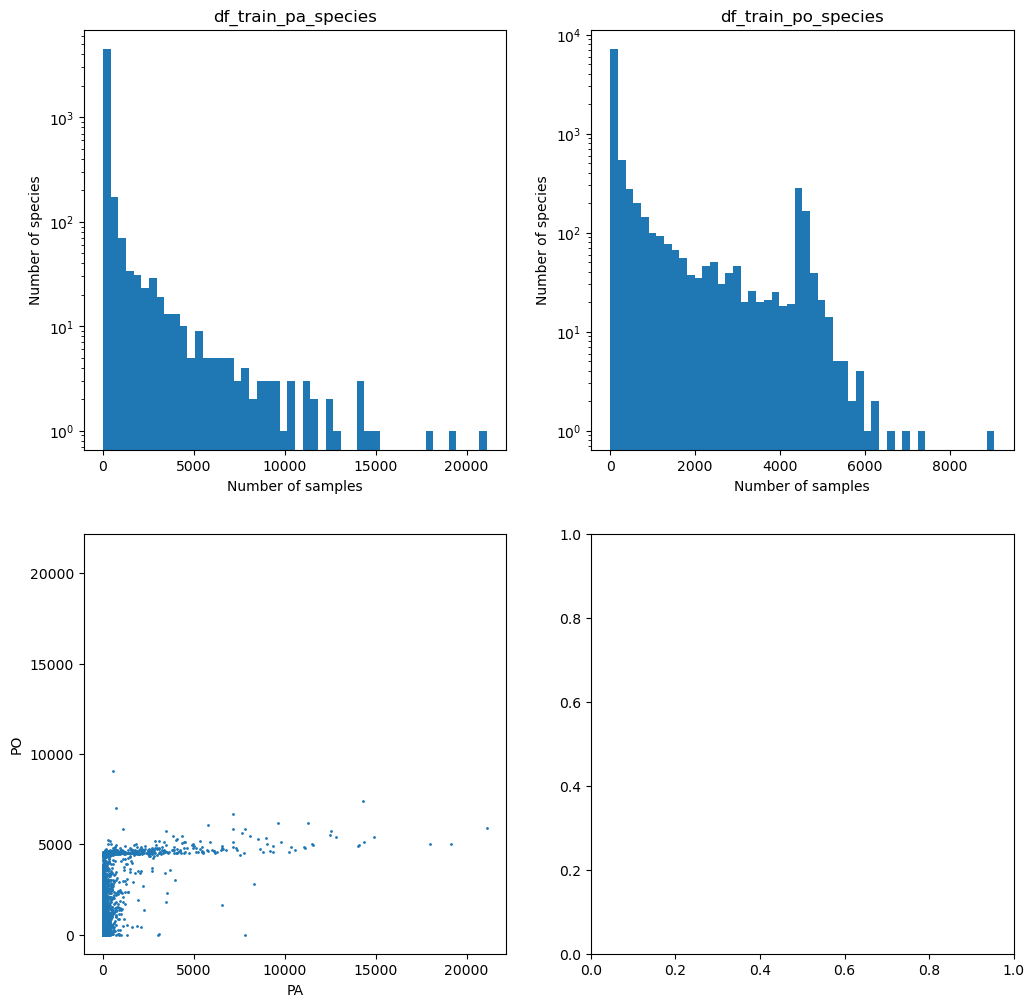

In [59]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

for iplot, name in enumerate(['df_train_pa_species', 'df_train_po_species']):
    curr_ax = ax[0, iplot]
    curr_ax.hist(dict_dfs_species[name].value_counts('speciesId').values, bins=50)
    curr_ax.set_yscale('log')
    curr_ax.set_title(name)
    curr_ax.set_xlabel('Number of samples')
    curr_ax.set_ylabel('Number of species')

curr_ax = ax[1, 0]
val_counts_pa = dict_dfs_species['df_train_pa_species'].value_counts('speciesId')
val_counts_po = dict_dfs_species['df_train_po_species'].value_counts('speciesId')
joint_counts_overlap = np.zeros((val_counts_pa.shape[0], 2))
for i, species_id in enumerate(val_counts_pa.index):
    joint_counts_overlap[i, 0] = val_counts_pa[species_id]
    joint_counts_overlap[i, 1] = val_counts_po.get(species_id, 0)

curr_ax.scatter(joint_counts_overlap[:, 0], joint_counts_overlap[:, 1], s=1)
curr_ax.set_xlabel('PA')
curr_ax.set_ylabel('PO')
# curr_ax.set_xlim([-100, 5000])
# curr_ax.set_ylim([-100, 5000])
rfv.equal_xy_lims(curr_ax)

In [54]:
np.corrcoef(joint_counts_overlap[:, 0], joint_counts_overlap[:, 1])

array([[1.        , 0.49285855],
       [0.49285855, 1.        ]])

In [7]:
tmp = dlu.load_multiple_env_raster()
tmp

,surveyId,Elevation,LandCover,Soilgrid-bdod,Soilgrid-cec,Soilgrid-cfvo,Soilgrid-clay,Soilgrid-nitrogen,Soilgrid-phh2o,Soilgrid-sand,...,Bio10,Bio11,Bio12,Bio13,Bio14,Bio15,Bio16,Bio17,Bio18,Bio19
0,212,47.0,8.0,140.0,214.0,151.0,292.0,159.0,73.0,284.0,...,2958,2816,6355,933,143,395,2282,770,770,1917
1,222,6.0,12.0,120.0,225.0,101.0,94.0,379.0,58.0,650.0,...,2890,2746,7286,792,376,201,2283,1336,2076,1653
2,243,10.0,5.0,115.0,261.0,86.0,131.0,373.0,54.0,750.0,...,2888,2759,8546,1117,372,295,2986,1438,2448,1838
3,324,116.0,14.0,118.0,179.0,117.0,225.0,230.0,57.0,238.0,...,2938,2802,10719,1163,564,197,3216,1948,1948,2926
4,333,84.0,14.0,138.0,233.0,176.0,328.0,250.0,71.0,231.0,...,2927,2792,9353,1095,503,249,3186,1638,1638,2677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88982,3919553,23.0,12.0,116.0,199.0,65.0,116.0,311.0,59.0,622.0,...,2887,2752,8000,919,408,218,2505,1425,2187,1723
88983,3919592,138.0,1.0,118.0,245.0,113.0,156.0,405.0,54.0,555.0,...,2888,2748,6932,781,314,240,2242,1214,2029,1498
88984,3919620,37.0,12.0,113.0,233.0,70.0,71.0,253.0,56.0,798.0,...,2887,2746,9745,1201,440,246,3167,1718,2489,2413
88985,3919640,131.0,1.0,130.0,162.0,99.0,55.0,234.0,50.0,803.0,...,2895,2722,7301,816,390,211,2357,1336,2357,1558
